<a href="https://colab.research.google.com/github/sakuna47/Chest-X-ray-Images-Pneumonia-/blob/Backend/XRayBackend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow flask pillow imbalanced-learn matplotlib seaborn

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from flask import Flask, request, render_template
from PIL import Image
import joblib

In [3]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Normal: 1341, Pneumonia: 3875


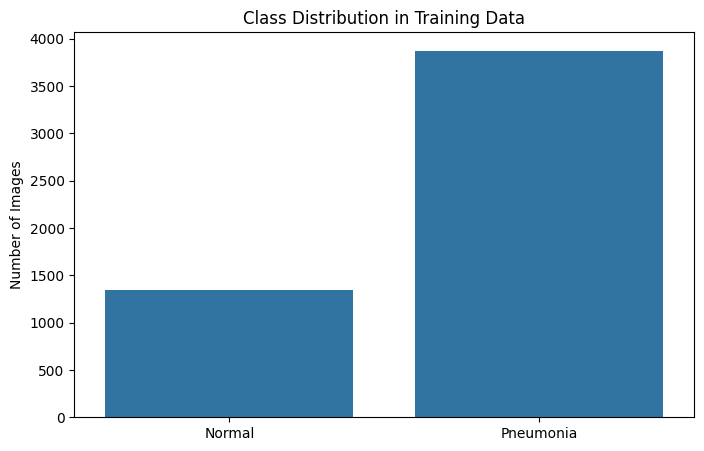

In [4]:


# Define  paths
base_dir = "/content/drive/My Drive/Medical Diagnosis with X-ray Images/chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

# Count images in each class
normal_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
pneumonia_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))

print(f"Normal: {normal_count}, Pneumonia: {pneumonia_count}")

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=["Normal", "Pneumonia"], y=[normal_count, pneumonia_count])
plt.title("Class Distribution in Training Data")
plt.ylabel("Number of Images")
plt.show()


In [5]:
# Create a DataFrame for image paths and labels
image_paths = []
labels = []

for label in ["NORMAL", "PNEUMONIA"]:
    class_dir = os.path.join(train_dir, label)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(label)

df = pd.DataFrame({"image_path": image_paths, "label": labels})

# Encode labels
df["label"] = df["label"].map({"NORMAL": 0, "PNEUMONIA": 1})

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
df_resampled, _ = ros.fit_resample(df[["image_path"]], df["label"])
df_resampled["label"] = 1  # All resampled images are pneumonia
df_balanced = pd.concat([df, df_resampled])